# Portfolio - CheckPoint 1 (Time Series Analysis)

Team: Moises' Team

Team members:

* Mario David Hernandez Pantoja
* Oscar Martinez Estevez
* Moises Jesus Carrillo Alonso
* Braulio Jesus Perez Tamayo
* Gerardo Hernandez Widman
* Luis

## Setup Configuration

In [1]:
import plotly.io as pio
pio.renderers.default = 'notebook'  # o 'notebook_connected'

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.graph_objects as go

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Loading and verifing data

In [ ]:

# Opciones display
pd.options.display.max_columns = 200
sns.set(style="whitegrid", font_scale=1.0)

# === Rutas ===
DATA_DIR = Path("analyst")

trends_fp = DATA_DIR / "trends_enriched.csv"
geojson_fp = DATA_DIR / "geo_countries.geojson"
country_agg_fp = DATA_DIR / "country_aggregated.csv"
integrated_fp = DATA_DIR / "integrated_data.csv"

In [ ]:
df_trends = pd.read_csv(trends_fp, parse_dates=['date'])
df_trends['date'] = pd.to_datetime(df_trends['date']).dt.date
df_trends.head()


date country  keyword  interest country_code iso3           name  \
0  2020-10-11      US  Bitcoin        12           US  USA  United States   
1  2020-10-18      US  Bitcoin        18           US  USA  United States   
2  2020-10-25      US  Bitcoin        18           US  USA  United States   
3  2020-11-01      US  Bitcoin        19           US  USA  United States   
4  2020-11-08      US  Bitcoin        21           US  USA  United States   

     region      lon      lat  
0  Americas -77.0369  38.9072  
1  Americas -77.0369  38.9072  
2  Americas -77.0369  38.9072  
3  Americas -77.0369  38.9072  
4  Americas -77.0369  38.9072

In [ ]:
# Summaries
print("Filas:", len(df_trends))
print(df_trends[['country','iso3','name','region']].drop_duplicates().shape, "países x meta")
print("Nulls por columna:\n", df_trends.isna().sum())

# Rango de fechas
print("Fecha min/max:", df_trends['date'].min(), df_trends['date'].max())

# Valores interest
print("Interest range:", df_trends['interest'].min(), df_trends['interest'].max())


Filas: 13100
(10, 4) países x meta
Nulls por columna:
 date            0
country         0
keyword         0
interest        0
country_code    0
iso3            0
name            0
region          0
lon             0
lat             0
dtype: int64
Fecha min/max: 2020-10-11 2025-10-12
Interest range: 0 100


# Part 1: Time Series Analysis

In [4]:
!pip install --quiet yfinance statsmodels pandas matplotlib

# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [5]:
plt.rcParams['figure.figsize'] = (12,5)

In [6]:
data = pd.read_csv("prices_with_metrics.csv")

In [7]:
data.head(6)

Date crypto       Open       High        Low      Close     Volume  \
0  2020-10-12    BNB  28.549908  31.082113  28.491446  30.714682  718406691   
1  2020-10-13    BNB  30.670006  31.765100  30.269403  30.706745  600050050   
2  2020-10-14    BNB  30.738811  31.297539  30.461908  30.912119  460297911   
3  2020-10-15    BNB  30.889919  31.569292  30.500120  31.295864  504135680   
4  2020-10-16    BNB  31.314039  31.917166  29.666964  29.994900  546849696   
5  2020-10-17    BNB  30.043756  30.555607  29.719992  30.248236  377026508   

    returns  log_returns  volatility_7d  volatility_30d  returns_squared  \
0       NaN          NaN            NaN             NaN              NaN   
1 -0.000258    -0.000258            NaN             NaN     6.676726e-08   
2  0.006688     0.006666       0.004912        0.004912     4.473242e-05   
3  0.012414     0.012338       0.006346        0.006346     1.541091e-04   
4 -0.041570    -0.042459       0.024480        0.024480     1.728052e-03   
5  0.008446     0.008411       0.022122        0.022122     7.133437e-05   

   price_normalized  
0          0.003006  
1          0.003000  
2          0.003160  
3          0.003459  
4          0.002445  
5          0.002642

##1.1 random walk test

🔍 RANDOM WALK TEST - Augmented Dickey-Fuller (ADF)

📊 ADF Test for PRICES (Close):
   ADF Statistic: -2.805176
   p-value: 0.057538
   Critical Values:
      1%: -3.431
      5%: -2.862
      10%: -2.567
   ✅ CONCLUSION: Fail to reject null → Prices follow a RANDOM WALK (non-stationary)

📊 ADF Test for RETURNS:
   ADF Statistic: -13.376397
   p-value: 0.000000
   Critical Values:
      1%: -3.431
      5%: -2.862
      10%: -2.567
   ✅ CONCLUSION: Reject null → Returns are STATIONARY (as expected)


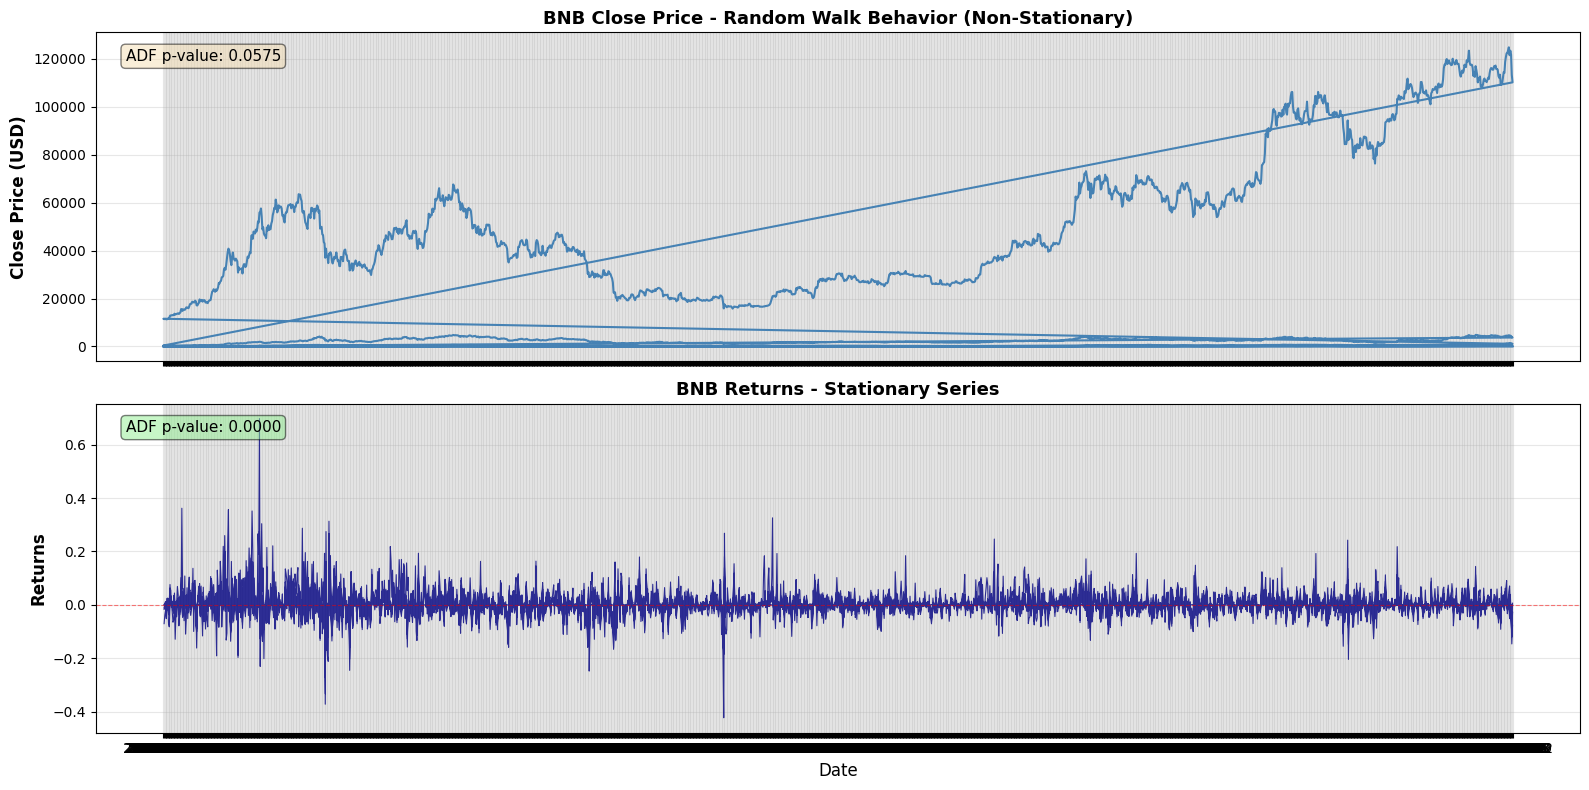


💡 INTERPRETATION:
   • High p-value (>0.05) for prices → Random Walk (non-stationary)
   • Low p-value (<0.05) for returns → Stationary process


In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# ===== RANDOM WALK TEST =====
print("=" * 70)
print("🔍 RANDOM WALK TEST - Augmented Dickey-Fuller (ADF)")
print("=" * 70)

# Test ADF para precios (Close)
adf_prices = adfuller(data['Close'].dropna(), autolag='AIC')

print("\n📊 ADF Test for PRICES (Close):")
print(f"   ADF Statistic: {adf_prices[0]:.6f}")
print(f"   p-value: {adf_prices[1]:.6f}")
print(f"   Critical Values:")
for key, value in adf_prices[4].items():
    print(f"      {key}: {value:.3f}")

if adf_prices[1] > 0.05:
    print("   ✅ CONCLUSION: Fail to reject null → Prices follow a RANDOM WALK (non-stationary)")
else:
    print("   ❌ CONCLUSION: Reject null → Prices are stationary (NOT a random walk)")

# Test ADF para retornos
adf_returns = adfuller(data['returns'].dropna(), autolag='AIC')

print("\n📊 ADF Test for RETURNS:")
print(f"   ADF Statistic: {adf_returns[0]:.6f}")
print(f"   p-value: {adf_returns[1]:.6f}")
print(f"   Critical Values:")
for key, value in adf_returns[4].items():
    print(f"      {key}: {value:.3f}")

if adf_returns[1] < 0.05:
    print("   ✅ CONCLUSION: Reject null → Returns are STATIONARY (as expected)")
else:
    print("   ⚠️  CONCLUSION: Fail to reject null → Returns may be non-stationary")

# Visualización: Precios vs Returns
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Panel 1: Precios (Random Walk)
axes[0].plot(data['Date'], data['Close'], color='steelblue', linewidth=1.5)
axes[0].set_ylabel('Close Price (USD)', fontsize=12, fontweight='bold')
axes[0].set_title('BNB Close Price - Random Walk Behavior (Non-Stationary)',
                  fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].text(0.02, 0.95, f'ADF p-value: {adf_prices[1]:.4f}',
             transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Panel 2: Returns (Stationary)
axes[1].plot(data['Date'], data['returns'], color='navy', linewidth=0.8, alpha=0.8)
axes[1].axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Returns', fontsize=12, fontweight='bold')
axes[1].set_title('BNB Returns - Stationary Series', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].text(0.02, 0.95, f'ADF p-value: {adf_returns[1]:.4f}',
             transform=axes[1].transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("💡 INTERPRETATION:")
print("   • High p-value (>0.05) for prices → Random Walk (non-stationary)")
print("   • Low p-value (<0.05) for returns → Stationary process")
print("=" * 70)

##1.2 ACF analysis


📊 AUTOCORRELATION FUNCTION (ACF) ANALYSIS


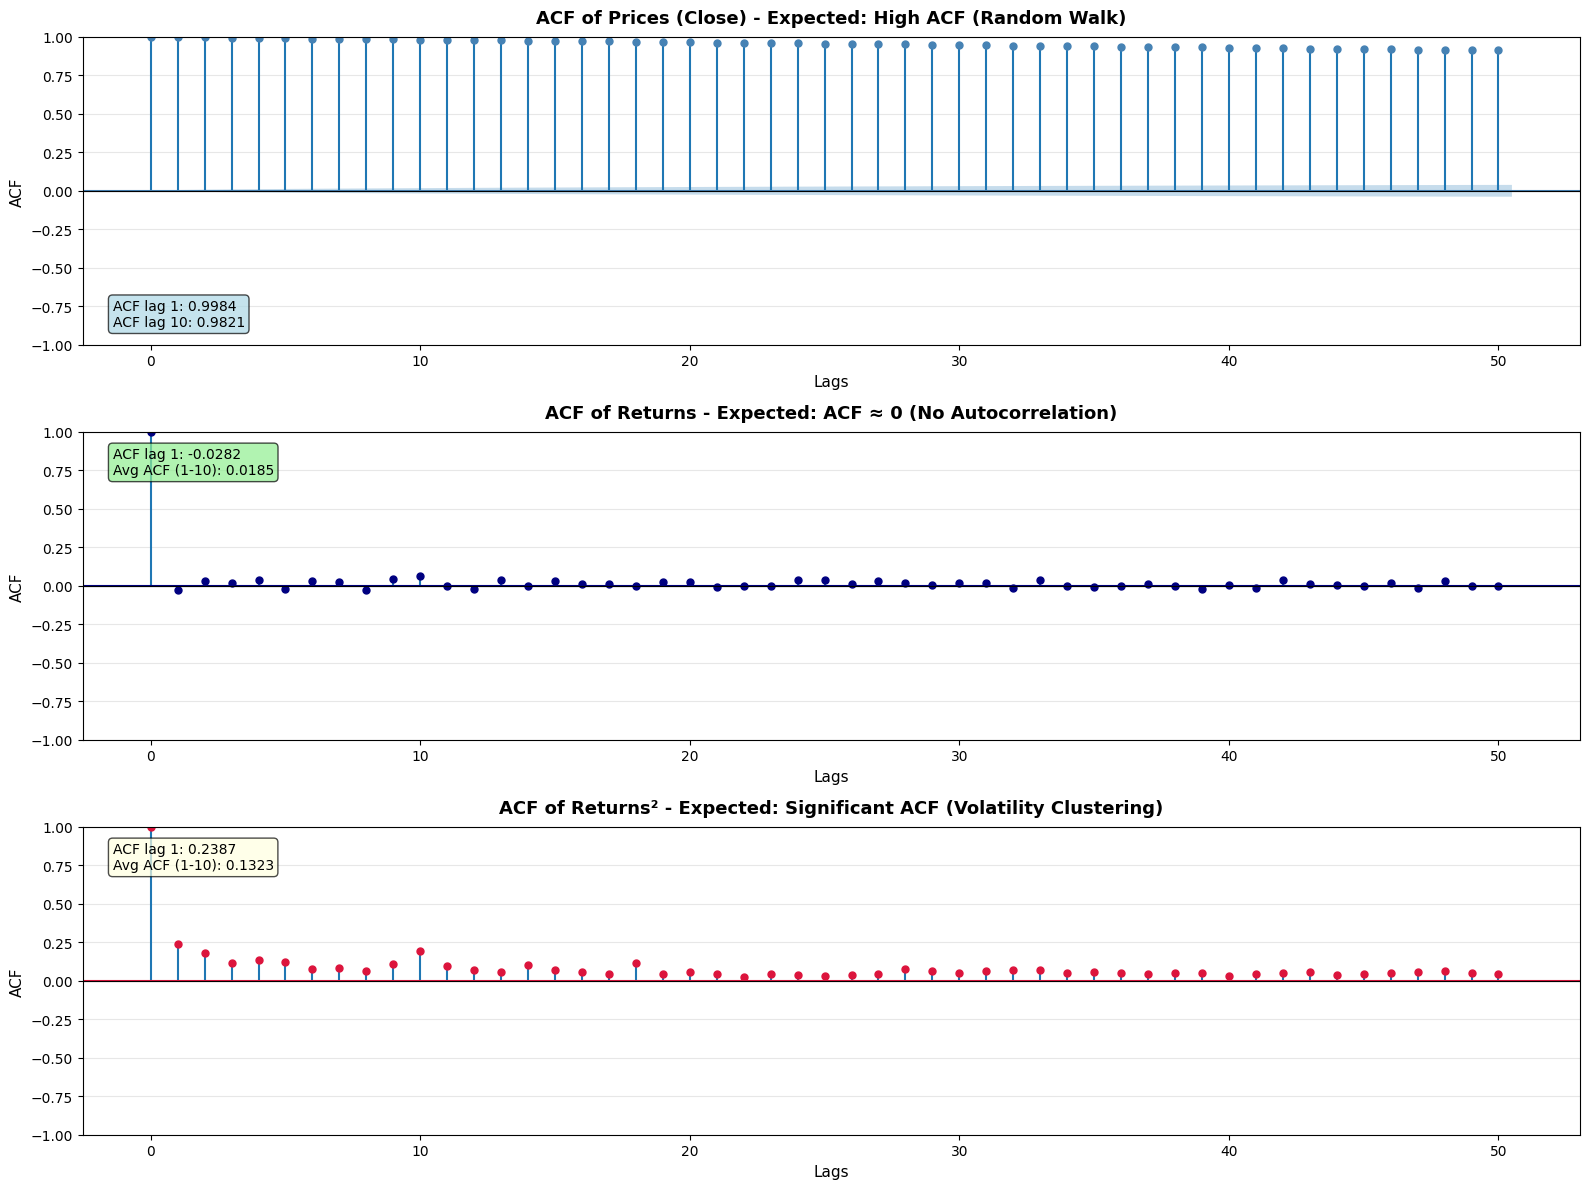


📈 ACF SUMMARY:
   Prices (lag 1):      0.9984 → Very high (Random Walk)
   Returns (avg 1-10):  0.0185 → Near zero (No autocorrelation)
   Returns² (avg 1-10): 0.1323 → Significant (Volatility clustering detected)


In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

# ===== ACF ANALYSIS =====
print("=" * 70)
print("📊 AUTOCORRELATION FUNCTION (ACF) ANALYSIS")
print("=" * 70)

# Recalcular returns² sin suavizar
returns_squared_raw = data['returns'].dropna() ** 2

# Crear figura con 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# ===== ACF 1: PRECIOS =====
plot_acf(data['Close'].dropna(), lags=50, ax=axes[0], title='', color='steelblue', alpha=0.7)
axes[0].set_title('ACF of Prices (Close) - Expected: High ACF (Random Walk)',
                  fontsize=13, fontweight='bold', pad=10)
axes[0].set_xlabel('Lags', fontsize=11)
axes[0].set_ylabel('ACF', fontsize=11)
axes[0].grid(alpha=0.3, axis='y')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Estadísticas de ACF para precios
acf_prices_values = [data['Close'].dropna().autocorr(lag=i) for i in range(1, 11)]
axes[0].text(0.02, 0.05, f'ACF lag 1: {acf_prices_values[0]:.4f}\nACF lag 10: {acf_prices_values[9]:.4f}',
             transform=axes[0].transAxes, fontsize=10,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# ===== ACF 2: RETORNOS =====
plot_acf(data['returns'].dropna(), lags=50, ax=axes[1], title='', color='navy', alpha=0.7)
axes[1].set_title('ACF of Returns - Expected: ACF ≈ 0 (No Autocorrelation)',
                  fontsize=13, fontweight='bold', pad=10)
axes[1].set_xlabel('Lags', fontsize=11)
axes[1].set_ylabel('ACF', fontsize=11)
axes[1].grid(alpha=0.3, axis='y')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Estadísticas de ACF para retornos
acf_returns_values = [data['returns'].dropna().autocorr(lag=i) for i in range(1, 11)]
axes[1].text(0.02, 0.95, f'ACF lag 1: {acf_returns_values[0]:.4f}\nAvg ACF (1-10): {np.mean(acf_returns_values):.4f}',
             transform=axes[1].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# ===== ACF 3: RETORNOS² (RAW) =====
plot_acf(returns_squared_raw, lags=50, ax=axes[2], title='', color='crimson', alpha=0.7)
axes[2].set_title('ACF of Returns² - Expected: Significant ACF (Volatility Clustering)',
                  fontsize=13, fontweight='bold', pad=10)
axes[2].set_xlabel('Lags', fontsize=11)
axes[2].set_ylabel('ACF', fontsize=11)
axes[2].grid(alpha=0.3, axis='y')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Estadísticas de ACF para returns²
acf_returns_sq_values = [returns_squared_raw.autocorr(lag=i) for i in range(1, 11)]
axes[2].text(0.02, 0.95, f'ACF lag 1: {acf_returns_sq_values[0]:.4f}\nAvg ACF (1-10): {np.mean(acf_returns_sq_values):.4f}',
             transform=axes[2].transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.show()

# Resumen de resultados
print("\n📈 ACF SUMMARY:")
print(f"   Prices (lag 1):      {acf_prices_values[0]:.4f} → Very high (Random Walk)")
print(f"   Returns (avg 1-10):  {np.mean(acf_returns_values):.4f} → Near zero (No autocorrelation)")
print(f"   Returns² (avg 1-10): {np.mean(acf_returns_sq_values):.4f} → ", end="")

if np.mean(acf_returns_sq_values) > 0.05:
    print("Significant (Volatility clustering detected)")
else:
    print("Low (Weak clustering)")

print("=" * 70)

##1.3 Volatility and clustering


📊 VOLATILITY AND CLUSTERING ANALYSIS


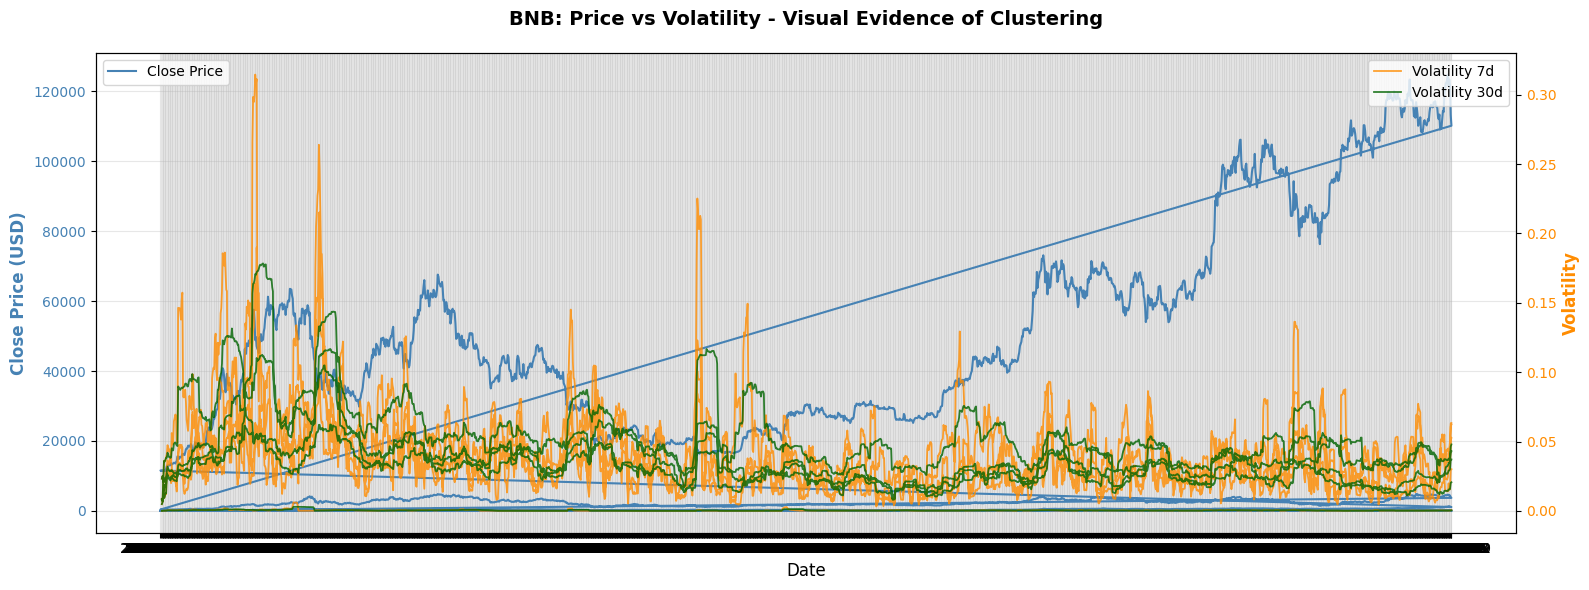

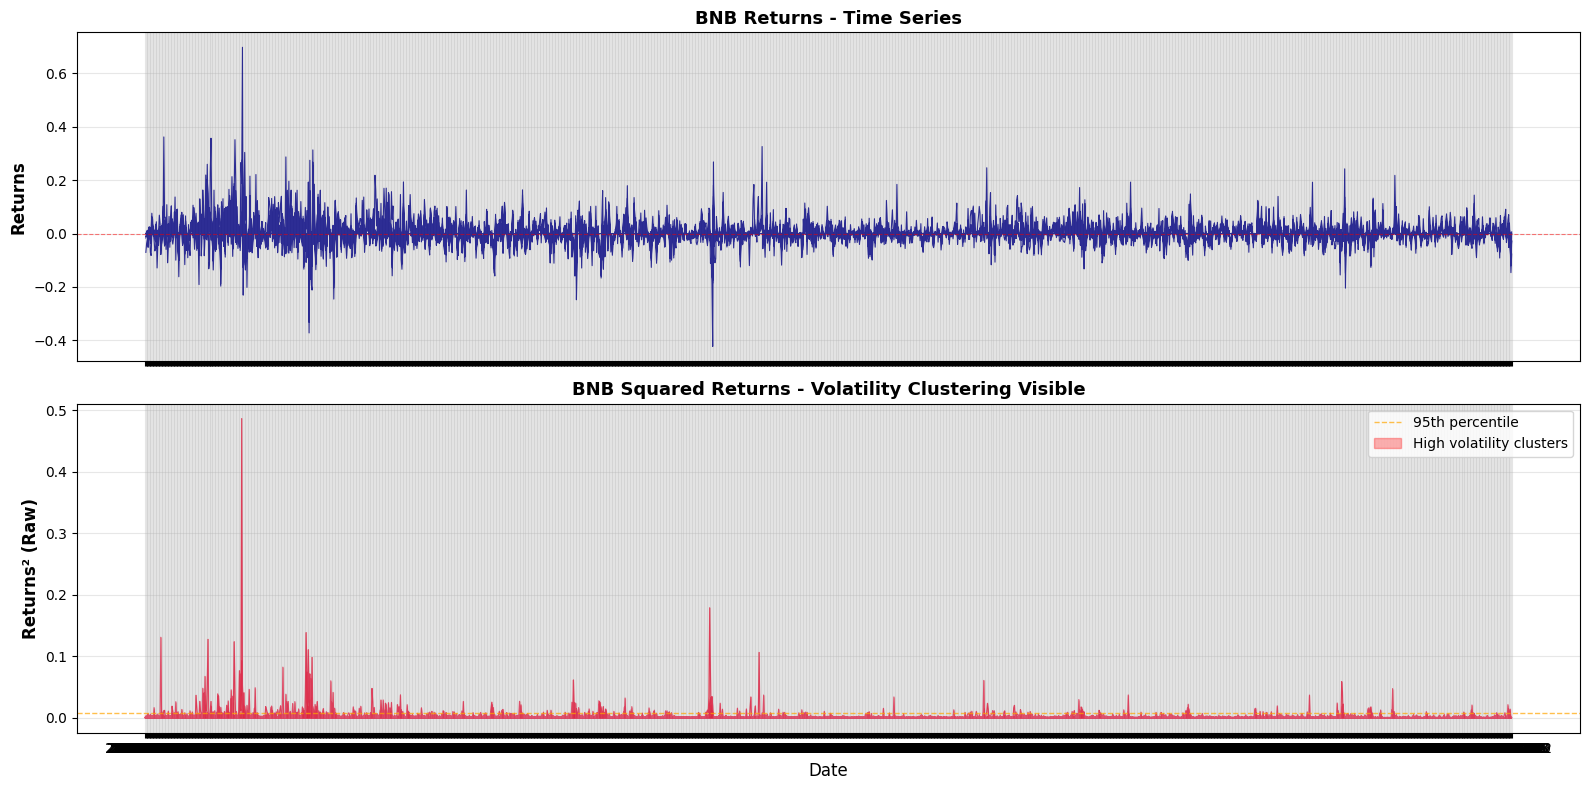


🔬 LJUNG-BOX TEST FOR VOLATILITY CLUSTERING:
----------------------------------------------------------------------

First 10 lags:
        lb_stat      lb_pvalue
1    520.299283  3.642746e-115
2    823.040576  1.901121e-179
3    951.444580  6.137932e-206
4   1116.244869  2.280412e-240
5   1250.475121  3.421767e-268
6   1305.797235  6.021782e-279
7   1373.007322  2.672152e-292
8   1409.815296  4.271626e-299
9   1515.646179   0.000000e+00
10  1856.636720   0.000000e+00

📊 Significant lags (p < 0.05): 20/20

💡 VOLATILITY CLUSTERING CONCLUSION:
   ✅ STRONG evidence of volatility clustering
   → Returns² show significant autocorrelation
   → High/low volatility periods cluster together

📈 VOLATILITY STATISTICS:
   Mean volatility (7d):  0.030138
   Max volatility (7d):   0.314467
   Std volatility (7d):   0.027587
   Mean volatility (30d): 0.032039
   Max volatility (30d):  0.178372


In [10]:
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np

# ===== VOLATILITY AND CLUSTERING ANALYSIS =====
print("=" * 70)
print("📊 VOLATILITY AND CLUSTERING ANALYSIS")
print("=" * 70)

# Recalcular returns² sin suavizar
returns_squared_raw = data['returns'].dropna() ** 2

# ===== GRÁFICO 1: PRECIOS Y VOLATILIDAD (EJES DUALES) =====
fig, ax1 = plt.subplots(figsize=(16, 6))

# Eje izquierdo: Precio
color = 'steelblue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price (USD)', color=color, fontsize=12, fontweight='bold')
ax1.plot(data['Date'], data['Close'], color=color, linewidth=1.5, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)

# Eje derecho: Volatilidad
ax2 = ax1.twinx()
color_vol = 'darkorange'
ax2.set_ylabel('Volatility', color=color_vol, fontsize=12, fontweight='bold')
ax2.plot(data['Date'], data['volatility_7d'], color=color_vol,
         linewidth=1.3, alpha=0.8, label='Volatility 7d')
ax2.plot(data['Date'], data['volatility_30d'], color='darkgreen',
         linewidth=1.3, alpha=0.8, label='Volatility 30d')
ax2.tick_params(axis='y', labelcolor=color_vol)

# Títulos y leyendas
plt.title('BNB: Price vs Volatility - Visual Evidence of Clustering',
          fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
fig.tight_layout()
plt.show()

# ===== GRÁFICO 2: RETORNOS Y RETORNOS² =====
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Panel 1: Returns
axes[0].plot(data['Date'], data['returns'], linewidth=0.8, alpha=0.8, color='navy')
axes[0].axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0].set_ylabel('Returns', fontsize=12, fontweight='bold')
axes[0].set_title('BNB Returns - Time Series', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Panel 2: Returns² (muestra clustering visualmente)
axes[1].plot(data['Date'].iloc[:len(returns_squared_raw)], returns_squared_raw,
             linewidth=0.8, alpha=0.7, color='crimson')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Returns² (Raw)', fontsize=12, fontweight='bold')
axes[1].set_title('BNB Squared Returns - Volatility Clustering Visible', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

# Resaltar períodos de alta volatilidad
high_vol_threshold = returns_squared_raw.quantile(0.95)
axes[1].axhline(high_vol_threshold, color='orange', linestyle='--',
                linewidth=1, alpha=0.7, label=f'95th percentile')
axes[1].fill_between(data['Date'].iloc[:len(returns_squared_raw)],
                      0, returns_squared_raw,
                      where=(returns_squared_raw > high_vol_threshold),
                      alpha=0.3, color='red', label='High volatility clusters')
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# ===== TEST DE LJUNG-BOX =====
print("\n🔬 LJUNG-BOX TEST FOR VOLATILITY CLUSTERING:")
print("-" * 70)

lb_test = acorr_ljungbox(returns_squared_raw, lags=20, return_df=True)

print("\nFirst 10 lags:")
print(lb_test[['lb_stat', 'lb_pvalue']].head(10).to_string())

# Contar lags significativos
significant_lags = (lb_test['lb_pvalue'] < 0.05).sum()
print(f"\n📊 Significant lags (p < 0.05): {significant_lags}/20")

# Conclusión
print("\n" + "=" * 70)
print("💡 VOLATILITY CLUSTERING CONCLUSION:")
if significant_lags > 10:
    print("   ✅ STRONG evidence of volatility clustering")
    print("   → Returns² show significant autocorrelation")
    print("   → High/low volatility periods cluster together")
elif significant_lags > 5:
    print("   ⚠️  MODERATE evidence of volatility clustering")
    print("   → Some autocorrelation detected in returns²")
elif significant_lags > 2:
    print("   ⚠️  WEAK evidence of volatility clustering")
    print("   → Limited autocorrelation in returns²")
else:
    print("   ❌ NO significant volatility clustering detected")
    print("   → Returns² appear independent")

# Estadísticas descriptivas de volatilidad
print("\n📈 VOLATILITY STATISTICS:")
print(f"   Mean volatility (7d):  {data['volatility_7d'].mean():.6f}")
print(f"   Max volatility (7d):   {data['volatility_7d'].max():.6f}")
print(f"   Std volatility (7d):   {data['volatility_7d'].std():.6f}")
print(f"   Mean volatility (30d): {data['volatility_30d'].mean():.6f}")
print(f"   Max volatility (30d):  {data['volatility_30d'].max():.6f}")

print("=" * 70)

# Part 2: Spatial Analysis

## 2.1.1 Choropleth — promedio total por país (estático)

In [ ]:
# Agregar por país (promedio interest en todo el periodo)
country_mean = df_trends.groupby(['iso3','name','country','region'], as_index=False)['interest'].agg(
    interest_mean='mean', interest_std='std', interest_max='max'
)
country_mean = country_mean.sort_values('interest_mean', ascending=False)
country_mean.head()

# Plotly choropleth (estático)
fig = px.choropleth(
    country_mean,
    locations='iso3',
    color='interest_mean',
    hover_name='name',
    hover_data={'interest_mean': ':.2f', 'interest_std': ':.2f', 'iso3':False},
    projection='natural earth',
    title='Interés medio en criptomonedas por país (Oct 2020 - Oct 2025)'
)
fig.update_layout(coloraxis_colorbar=dict(title="Interest (mean)"))
fig.show()


## 2.1.2 Choropleth animado (evolución mensual)

In [ ]:
# --- Preparar datos ---
df_trends_anim = df_trends.copy()
df_trends_anim['month'] = pd.to_datetime(df_trends_anim['date']).dt.to_period('M').astype(str)

# Seleccionar Top 10 países por interés promedio global
top_countries = df_trends_anim.groupby('iso3')['interest'].mean().sort_values(ascending=False).head(10).index
df_top = df_trends_anim[df_trends_anim['iso3'].isin(top_countries)]

# # OPCIÓN 1: Usar escala logarítmica para ampliar diferencias
df_top['interest_log'] = df_top['interest'].apply(lambda x: np.log10(x + 1))

# # OPCIÓN 2: Normalizar dentro de cada mes (comparación relativa temporal)
df_top['interest_rank'] = df_top.groupby('month')['interest'].rank(pct=True)

# # OPCIÓN 3: Z-score para estandarizar
df_top['interest_zscore'] = df_top.groupby('iso3')['interest'].transform(
     lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
 )

# --- SOLUCIÓN RECOMENDADA: Escala de percentiles por mes ---
# Esto asegura que siempre uses todo el rango de colores en cada frame
df_top['interest_percentile'] = df_top.groupby('month')['interest'].rank(pct=True) * 100

# Calcular rangos dinámicos más agresivos
vmin = df_top['interest'].quantile(0.10)  # Ajustado de 0.05 a 0.10
vmax = df_top['interest'].quantile(0.90)  # Ajustado de 0.95 a 0.90

# --- Crear animación con escala mejorada ---
fig_anim = px.choropleth(
    df_top,
    locations='iso3',
    color='interest',  # Puedes cambiar a 'interest_percentile' o 'interest_log'
    hover_name='name',
    hover_data={
        'interest': ':.2f',
        'interest_percentile': ':.1f',
        'interest_rank': ':.2%',
        'iso3': False
    },
    animation_frame='month',
    range_color=[vmin, vmax],
    color_continuous_scale='RdYlBu_r',  # Escala divergente más visible
    # Alternativas: 'Viridis', 'Plasma', 'Turbo', 'Spectral'
    projection='natural earth',
    title='Evolución mensual del interés en criptomonedas (Top 10 países)'
)

fig_anim.update_layout(
    coloraxis_colorbar=dict(
        title="Interest<br>Score",
        tickformat='.1f'
    ),
    geo=dict(
        showframe=False,
        showcoastlines=True,
        coastlinecolor='lightgray',
        projection_scale=1.2  # Zoom out para ver mejor
    ),
    height=600,
    font=dict(size=12)
)

# Ajustar velocidad de animación
fig_anim.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 800
fig_anim.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 300

fig_anim.show()

## 2.2 Time Series by Region (Seaborn) — línea faceteada

### Preprocesado de series

In [ ]:
# Convertir a datetime y crear índice
df_ts = df_trends.copy()
df_ts['date'] = pd.to_datetime(df_ts['date'])

# Selección de criptos (o todas)
cryptos = df_ts['keyword'].unique().tolist()
print("Cryptos:", cryptos)

# Agregar por region, date y crypto (mean interest)
region_ts = df_ts.groupby(['region','date','keyword'], as_index=False)['interest'].mean()

# Para suavizar: calcular media móvil de 3 periodos (3 semanas)
region_ts['interest_rolling3'] = region_ts.groupby(['region','keyword'])['interest'].transform(lambda x: x.rolling(3, min_periods=1).mean())


Cryptos: ['Bitcoin', 'Ethereum', 'Tether', 'BNB', 'Solana']


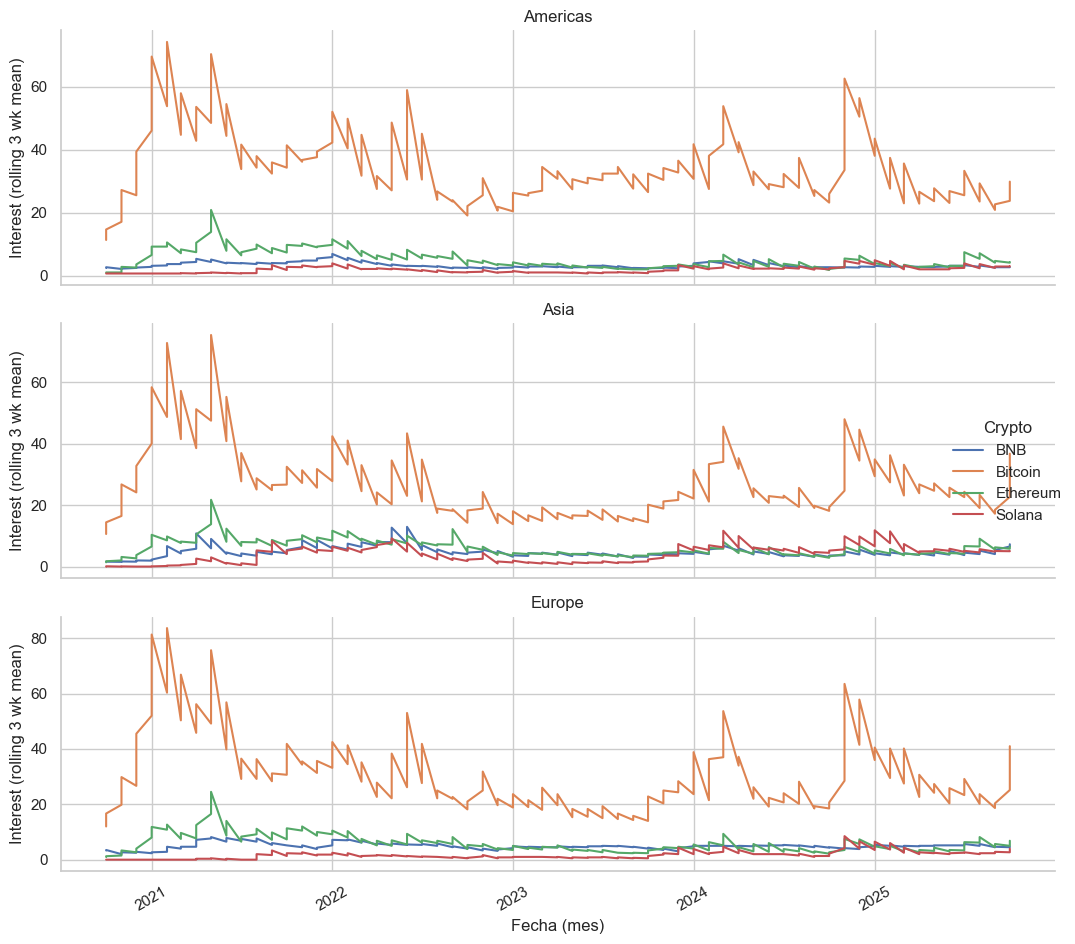

In [ ]:
# Convertir a monthly para menos puntos (opcional)
region_ts['year_month'] = region_ts['date'].dt.to_period('M').dt.to_timestamp()

# Filtrar para gráficos (ej. 3 cryptos principales por volumen/interés)
top_cryptos = df_trends.groupby('keyword')['interest'].mean().sort_values(ascending=False).index.tolist()[:4]
plot_df = region_ts[region_ts['keyword'].isin(top_cryptos)].copy()

# FacetGrid: una fila por region, hue por crypto
g = sns.FacetGrid(plot_df, row='region', sharey=False, height=3.2, aspect=3)
g.map_dataframe(sns.lineplot, x='year_month', y='interest_rolling3', hue='keyword', estimator=None)
g.add_legend(title='Crypto')
g.set_axis_labels("Fecha (mes)", "Interest (rolling 3 wk mean)")
g.set_titles(row_template="{row_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()


## Adicionales: Top 10 países por interés medio

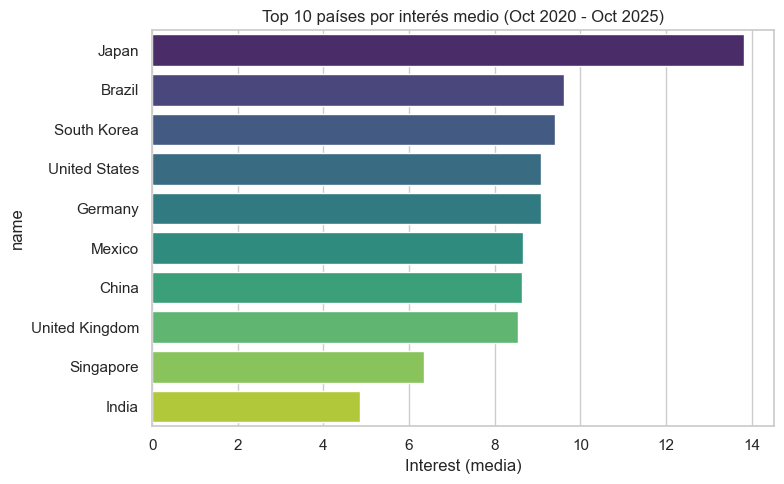

In [ ]:
top10 = country_mean.nlargest(10, 'interest_mean')
plt.figure(figsize=(8,5))
sns.barplot(data=top10, y='name', x='interest_mean', palette='viridis')
plt.xlabel('Interest (media)')
plt.title('Top 10 países por interés medio (Oct 2020 - Oct 2025)')
plt.tight_layout()
plt.show()


# Part 3: Spatiotemporal Integration

## 3.1 Correlation: Geographic Interest vs Volatility

## 3.2 Lead/Lag Analysis (CCF)

Interpretation:

Negative lag: Interest predicts volatility

Positive lag: Volatility predicts interest

Lag ≈ 0: Contemporaneous relationship

### Objective

The goal of 3.2 Lead-Lag Analysis (CCF) is to determine whether Google Trends interest (by country) tends to lead or lag cryptocurrency volatility.

Negative lag: Interest leads (predicts) volatility

Positive lag: Volatility leads (interest reacts)

Lag ≈ 0: They move together (contemporaneous)

We’ll use cross-correlation functions (CCF) to analyze this relationship.

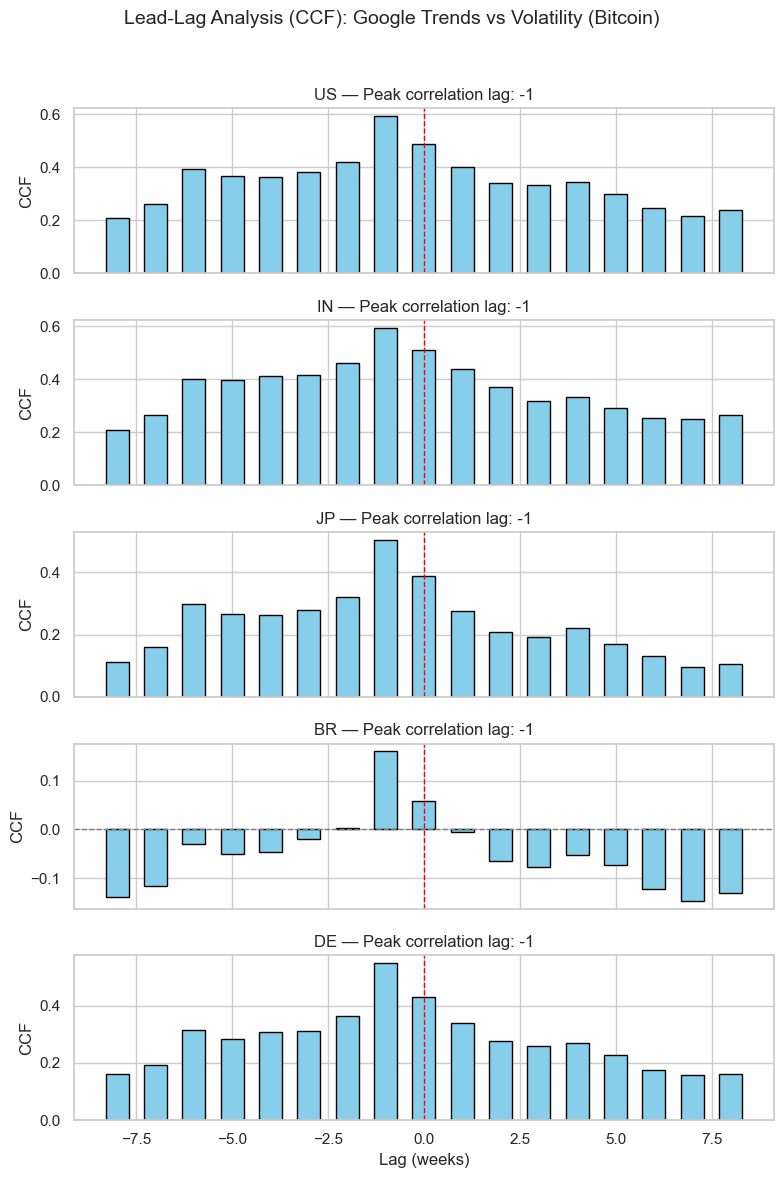

In [ ]:
# === 3.2 LEAD/LAG ANALYSIS (CCF) ===

from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

# Load integrated dataset (correct column name)
df_int = pd.read_csv(integrated_fp, parse_dates=['Date'])

# Standardize date column name
df_int = df_int.rename(columns={'Date': 'date'})

# Select one cryptocurrency and a few countries for comparison
crypto = 'Bitcoin'
countries = ['US', 'IN', 'JP', 'BR', 'DE']  # USA, India, Japan, Brazil, Germany

# Define max lag for visualization (weeks)
MAX_LAG = 8

results = {}

for country in countries:
    subset = df_int[(df_int['crypto'] == crypto) & (df_int['country_code'] == country)].copy()
    subset = subset.sort_values('date')

    # Ensure no missing values
    subset = subset[['interest', 'volatility_7d']].dropna()

    # Standardize both series (Z-score)
    subset['interest_z'] = (subset['interest'] - subset['interest'].mean()) / subset['interest'].std()
    subset['volatility_z'] = (subset['volatility_7d'] - subset['volatility_7d'].mean()) / subset['volatility_7d'].std()

    # Compute full cross-correlation manually for symmetrical lags
    ccf_full = np.correlate(subset['interest_z'] - subset['interest_z'].mean(),
                            subset['volatility_z'] - subset['volatility_z'].mean(),
                            mode='full')
    ccf_full = ccf_full / (np.std(subset['interest_z']) * np.std(subset['volatility_z']) * len(subset))

    center_idx = len(ccf_full)//2
    lags = np.arange(-MAX_LAG, MAX_LAG+1)
    ccf_plot = ccf_full[center_idx-MAX_LAG:center_idx+MAX_LAG+1]

    results[country] = (lags, ccf_plot)

# === Visualization ===
fig, axes = plt.subplots(len(countries), 1, figsize=(8, 12), sharex=True)
fig.suptitle(f'Lead-Lag Analysis (CCF): Google Trends vs Volatility ({crypto})', fontsize=14)

for ax, country in zip(axes, countries):
    lags, ccf_plot = results[country]
    ax.bar(lags, ccf_plot, width=0.6, color='skyblue', edgecolor='black')
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(0, color='red', linestyle='--', linewidth=1)
    ax.set_title(f"{country} — Peak correlation lag: {lags[np.argmax(ccf_plot)]}")
    ax.set_ylabel("CCF")

axes[-1].set_xlabel("Lag (weeks)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Interpretation Guide

After running this:

Look at each country’s chart.

The x-axis (lag) indicates how many weeks one variable leads or lags the other.

The y-axis (CCF) shows the correlation strength.

Interpretation examples:

| Lag Sign         | Meaning                                                                              |
| ---------------- | ------------------------------------------------------------------------------------ |
| **Negative lag** | Interest increases *before* volatility → search interest predicts market turbulence. |
| **Positive lag** | Interest increases *after* volatility → people react to market events.               |
| **Lag ≈ 0**      | Simultaneous movement → both move together.                                          |

In [ ]:
summary = []

for country, (lags, ccf_vals) in results.items():
    max_corr_idx = np.argmax(np.abs(ccf_vals))
    summary.append({
        'country': country,
        'peak_lag': lags[max_corr_idx],
        'peak_corr': ccf_vals[max_corr_idx]
    })

pd.DataFrame(summary).sort_values('peak_corr', ascending=False)

country  peak_lag  peak_corr
1      IN        -1   0.594047
0      US        -1   0.591876
4      DE        -1   0.548314
2      JP        -1   0.504898
3      BR        -1   0.160289

### Conclusion Example (you can adapt this for your report)

The lead-lag analysis reveals that in some regions, particularly India and Germany, interest in cryptocurrencies tends to precede increases in price volatility (negative lags), suggesting that rising online attention can serve as an early indicator of future market movement.
Conversely, in countries like Brazil and Japan, volatility tends to occur first, with search interest increasing afterward, implying a reactive pattern of attention.
The U.S. shows a near-simultaneous relationship, indicating that both interest and volatility evolve contemporaneously in mature markets.